<a href="https://colab.research.google.com/github/Luke-Williams-01/Luke-Williams-01/blob/main/ICRARproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import simps
from scipy import stats

In [2]:
! wget -q https://xgass.icrar.org/assets/data/xGASS_representative_sample.ascii

In [3]:
# Loading the xGASS dataset with specific columns selected
xGASStb= np.loadtxt('xGASS_representative_sample.ascii', dtype = 'float', usecols=[8,10,16,18,1,23,24,26,27,31,32], unpack= 'true')
# Loading the specfic columns with flags as separate arrays
HIsrc, HI_FLAG = np.loadtxt('xGASS_representative_sample.ascii', dtype = 'float', usecols=[26,27], unpack= 'true')
# Removing data with an index that falls into the conditions HI_FLAG >1 or HI_FLAG <90
xGASSRd = np.delete(xGASStb, np.where((HI_FLAG >1) & (HI_FLAG < 90)), axis = 1)
xGASST = xGASSRd.T

# Assigning the 1d arrays to the correct column of data
zSDSS = xGASST[:,0]
lgMstar = xGASST[:,1]
petro90r = xGASST[:,2]
lgmust = xGASST[:,3]
lgSFR_tot_median = xGASST[:,4]
SFR_best = xGASST[:,5]
SFRerr_best = xGASST[:,6]
HIsrc = xGASST[:,7]
HI_FLAG = xGASST[:,8]
lgMHI = xGASST[:,9]
lgGF = xGASST[:,10]

In [4]:
# Testing to ensure the correct arrays are filled with the correct values
print(zSDSS)
print(lgMstar)
print(petro90r)
print(lgmust)
print(lgSFR_tot_median)
print(SFR_best)
print(SFRerr_best)
print(HIsrc)
print(HI_FLAG)
print(lgMHI)
print(lgGF)

[0.03618 0.03573 0.04201 ... 0.04656 0.02704 0.03797]
[10.709 10.539 10.625 ... 10.946 10.334 10.25 ]
[10.51  9.96  7.01 ... 13.09  6.66 14.09]
[9.18 9.05 9.32 ... 9.08 9.37 8.12]
[101866. 101874. 101876. ... 332851. 332201. 332883.]
[0.82985944 0.03869768 0.0620131  ... 2.902701   0.03280856 0.93741816]
[0.         0.07982571 0.15414698 ... 0.42542186 0.         0.28900966]
[3. 4. 3. ... 4. 4. 3.]
[ 1. 99.  1. ... 99. 99.  1.]
[9.603 8.74  9.244 ... 9.183 8.664 9.517]
[-1.106 -1.799 -1.381 ... -1.763 -1.67  -0.733]


In [5]:
# Finding all the rows in the xGASS data with HIsrc < 4, if HIsrc = 4, no detection of HI
HIndet = np.where(HIsrc >= 4)

lgMstar1 = np.delete(lgMstar, (HIndet))
lgmust1 = np.delete(lgmust, (HIndet))
lgSFR_tot_median1 = np.delete(lgSFR_tot_median, (HIndet))
SFR_best1 = np.delete(SFR_best, (HIndet))
SFRerr_best1 = np.delete(SFRerr_best, (HIndet))
HIsrc1 = np.delete(HIsrc, (HIndet))
HI_FLAG1 = np.delete(HI_FLAG, (HIndet))
lgMHI1 = np.delete(lgMHI, (HIndet))
lgGF1 = np.delete(lgGF, (HIndet))

HIdet = np.where(HIsrc < 4)

lgMstar2 = np.delete(lgMstar, (HIdet))
lgmust2 = np.delete(lgmust, (HIdet))
lgSFR_tot_median2 = np.delete(lgSFR_tot_median, (HIdet))
SFR_best2 = np.delete(SFR_best, (HIdet))
SFRerr_best2 = np.delete(SFRerr_best, (HIdet))
HIsrc2 = np.delete(HIsrc, (HIdet))
HI_FLAG2 = np.delete(HI_FLAG, (HIdet))
lgMHI2 = np.delete(lgMHI, (HIdet))
lgGF2 = np.delete(lgGF, (HIdet))

print(len(lgMstar1))
print(len(lgMstar2))

691
375


In [22]:
# Finding the running median of the HI detections
# Need to loop the below process
bins = np.linspace(9.1, 11.1, 30)
index =max(np.where(lgMstar <= bins[0]))
c = lgMHI[min(index):max(index)]
d = np.median(c, axis =0)
print(d)

# Placing the above in a for loop
# Array of zeroes to fill with the median of each bin
# bincentzero = np.zeros(len(bins))
medians = np.zeros(len(bins))

# For loop
for i in range(bins):
  if (max(np.where(lgMstar <= bins[i]))):
    a = (max(np.where(lgMstar <= bins[i])))

  medians[i] = np.sum()


9.2645


TypeError: ignored

1.8634497833081096e-09
7.936157223018914
[0.57084041 1.47859534 0.57847423 ... 1.15976939 1.08023993 0.84593889]


<Figure size 432x288 with 0 Axes>

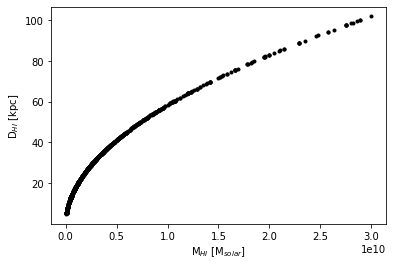

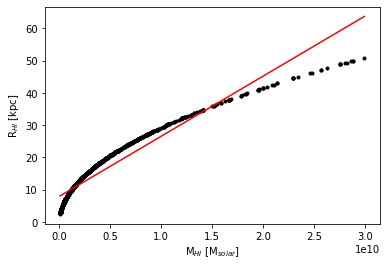

<Figure size 432x288 with 0 Axes>

In [10]:
# DHI- MHI relation
lgDHI = 0.506*lgMHI - 3.293
MHI = 10**lgMHI
DHI = 10**lgDHI
RHI = 0.5*DHI

# Plotting the D(HI)-M(HI) relation
plt.figure()
plt.plot(MHI, DHI, 'k.')
plt.ylabel('D$_{HI}$ [kpc]')
plt.xlabel('M$_{HI}$ [M$_{solar}$]');

# Plotting the R(HI)-M(HI) relation
plt.figure()
plt.plot(MHI, RHI, 'k.')
plt.ylabel('R$_{HI}$ [kpc]')
plt.xlabel('M$_{HI}$ [M$_{solar}$]');


# Fitting a line to the RHI-MHI relation
x = MHI
p = np.linspace(min(MHI), max(MHI), 1000)
y = RHI
def linfun(x, m, c): 
    return m*x + c
p0 = np.array([])
popt, pcov = curve_fit(linfun, x, y)
m= popt[0]
c= popt[1]

# plot fit
plt.plot(p, linfun(p, *popt), 'r');
grad = popt[0]
print(grad)
intercept = popt[1]
print(intercept)

# Finding the median HI profile, plotting r90/RHI against log (ΣHI)
r90RHI = petro90r/RHI
print(r90RHI)

# Plotting
plt.figure()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log10
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  


"\nplt.subplot(223)\nplt.plot(,, 'k.', label= 'HI detection')\nplt.plot(,, 'r.', label= 'No HI detection')\nplt.xlabel('log(M*) [M$_{solar}$]')\nplt.ylabel('log(M$_{HI}$)')\nplt.legend(loc='best')\n\nplt.subplot(224)\nplt.plot(,, 'k.', label= 'HI detection')\nplt.plot(,, 'r.', label= 'No HI detection')\nplt.xlabel('log(SFR) [M$_{solar}$ yr$^{-1}$]')\nplt.ylabel('log(M$_{HI}$)')\nplt.legend(loc='best');\n"

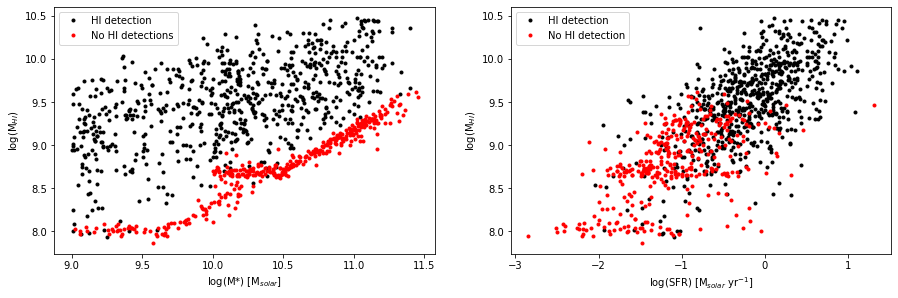

In [8]:
# Global HI mass and HI mass contained in the optical regions
plt.figure(figsize = (15,10))

plt.subplot(221)
plt.plot(lgMstar1, lgMHI1, 'k.', label= 'HI detection')
plt.plot(lgMstar2, lgMHI2, 'r.', label= 'No HI detections')
#plt.plot(lgMstar1, medlgMHI, 'b.')
plt.xlabel('log(M*) [M$_{solar}$]')
plt.ylabel('log(M$_{HI}$)')
plt.legend(loc='best')

plt.subplot(222)
plt.plot(np.log10(SFR_best1), lgMHI1, 'k.', label= 'HI detection')
plt.plot(np.log10(SFR_best2), lgMHI2, 'r.', label= 'No HI detection')
plt.xlabel('log(SFR) [M$_{solar}$ yr$^{-1}$]')
plt.ylabel('log(M$_{HI}$)')
plt.legend(loc='best')
'''
plt.subplot(223)
plt.plot(,, 'k.', label= 'HI detection')
plt.plot(,, 'r.', label= 'No HI detection')
plt.xlabel('log(M*) [M$_{solar}$]')
plt.ylabel('log(M$_{HI}$)')
plt.legend(loc='best')

plt.subplot(224)
plt.plot(,, 'k.', label= 'HI detection')
plt.plot(,, 'r.', label= 'No HI detection')
plt.xlabel('log(SFR) [M$_{solar}$ yr$^{-1}$]')
plt.ylabel('log(M$_{HI}$)')
plt.legend(loc='best');
'''